<a href="https://colab.research.google.com/github/CristinaMarsh/Learning_/blob/main/TStool/TFT_prediction_ver1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 12.3 MB/s 
     |████████████████████████████████| 585 kB 50.2 MB/s 
     |████████████████████████████████| 308 kB 50.7 MB/s 
     |████████████████████████████████| 81 kB 8.6 MB/s 
     |████████████████████████████████| 209 kB 49.3 MB/s 
     |████████████████████████████████| 419 kB 50.8 MB/s 
     |████████████████████████████████| 596 kB 50.7 MB/s 
     |████████████████████████████████| 140 kB 52.8 MB/s 
     |████████████████████████████████| 1.1 MB 35.5 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 45.1 MB/s 
     |████████████████████████████████| 271 kB 50.1 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 147 kB 49.6 MB/s 
     |████████████████████████████████|

# Case 1 单变量预测

In [2]:
path = r"https://raw.githubusercontent.com/pgpanagiotidis/Temporal-Fusion-Transformers-for-stock-price-forecasting/main/Pfizer.csv"

In [4]:
import os
import warnings
warnings.filterwarnings("ignore")  # avoid printing out absolute paths
import copy
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.examples import get_stallion_data
import csv
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [5]:
#read the data
df_Pfizer = pd.read_csv(path)

In [6]:
#convert column to datetime
df_Pfizer["Date"]= pd.to_datetime(df_Pfizer["Date"])

In [9]:
df_Pfizer.Date.max(), df_Pfizer.Date.min(),

(Timestamp('2021-05-13 00:00:00'), Timestamp('2015-05-01 00:00:00'))

In [10]:
df_Pfizer.Date.max()-df_Pfizer.Date.min(),

(Timedelta('2204 days 00:00:00'),)

In [11]:
df_Pfizer #数据频率不一致

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-05-01,32.125237,32.457306,32.125237,32.333965,24.998024,22706744
1,2015-05-04,32.362431,32.741936,32.305504,32.561668,25.174067,24864282
2,2015-05-05,32.609108,32.666035,32.267551,32.371918,25.027367,23590839
3,2015-05-06,32.020874,32.163189,31.508539,31.745731,24.746326,28309913
4,2015-05-07,31.726755,32.020874,31.622391,31.859583,24.835077,22669959
...,...,...,...,...,...,...,...
1515,2021-05-07,39.049999,39.869999,39.049999,39.580002,38.590019,33807800
1516,2021-05-10,39.830002,40.279999,39.779999,39.860001,38.863014,30831900
1517,2021-05-11,39.680000,40.070000,39.230000,39.349998,38.365772,30568600
1518,2021-05-12,39.439999,39.919998,39.310001,39.689999,38.697266,26208600


In [12]:
#add time index
# 忽视频率不一致
time_idx=np.arange(df_Pfizer.shape[0])
df_Pfizer["time_idx"] = time_idx

In [14]:
#create the group column
df_Pfizer['group']=[0 for i in range(0,1520)]

In [16]:
# keep only the necessary columns
df_Pfizer.drop(['Open', 'High', 'Low','Adj Close', 'Volume'], axis=1, inplace=True)

In [17]:
# 变成了单变量预测

,Date,Close,time_idx,group
0,2015-05-01,32.333965,0,0
1,2015-05-04,32.561668,1,0
2,2015-05-05,32.371918,2,0
3,2015-05-06,31.745731,3,0
4,2015-05-07,31.859583,4,0
...,...,...,...,...
1515,2021-05-07,39.580002,1515,0
1516,2021-05-10,39.860001,1516,0
1517,2021-05-11,39.349998,1517,0
1518,2021-05-12,39.689999,1518,0


## cut training and validation

In [18]:
#split the dataset into train, validation and test set
max_prediction_length = 3
max_encoder_length = 14

training_cutoff = int(df_Pfizer["time_idx"].max()*0.6)
print("training_cutoff",training_cutoff)

training = TimeSeriesDataSet(
        df_Pfizer[lambda x: x.time_idx <= training_cutoff],
        group_ids=["group"],
        target='Close',
        time_idx="time_idx",
        min_encoder_length=max_encoder_length,  # keep encoder length long (as it is in the validation set)
        max_encoder_length=max_encoder_length,
        min_prediction_length=max_prediction_length,
        max_prediction_length=max_prediction_length,
        time_varying_unknown_reals=['Close'],
        time_varying_known_reals=["time_idx"],
        target_normalizer=GroupNormalizer(
            groups=["group"], transformation="softplus"
        ),  # use softplus and normalize by group, SoftPlus is a smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive.
        add_relative_time_idx=True,
        add_target_scales=True,
        # add_encoder_length=True,
    )


training_cutoff 911


In [24]:
df_Pfizer[lambda x: x.time_idx <= training_cutoff]

,Date,Close,time_idx,group
0,2015-05-01,32.333965,0,0
1,2015-05-04,32.561668,1,0
2,2015-05-05,32.371918,2,0
3,2015-05-06,31.745731,3,0
4,2015-05-07,31.859583,4,0
...,...,...,...,...
907,2018-12-06,42.675522,907,0
908,2018-12-07,41.669830,908,0
909,2018-12-10,42.125237,909,0
910,2018-12-11,41.755219,910,0


In [23]:
df_Pfizer[lambda x: (x.time_idx > training_cutoff) & (x.time_idx <= validation_cutoff)]

,Date,Close,time_idx,group
912,2018-12-13,42.286530,912,0
913,2018-12-14,41.555977,913,0
914,2018-12-17,40.901329,914,0
915,2018-12-18,40.227703,915,0
916,2018-12-19,39.819733,916,0
...,...,...,...,...
1210,2020-02-21,33.889942,1210,0
1211,2020-02-24,32.893738,1211,0
1212,2020-02-25,32.191650,1212,0
1213,2020-02-26,32.941177,1213,0


In [25]:
df_Pfizer[lambda x: x.time_idx > validation_cutoff]

,Date,Close,time_idx,group
1215,2020-02-28,31.707781,1215,0
1216,2020-03-02,33.092979,1216,0
1217,2020-03-03,32.542694,1217,0
1218,2020-03-04,34.535103,1218,0
1219,2020-03-05,33.643265,1219,0
...,...,...,...,...
1515,2021-05-07,39.580002,1515,0
1516,2021-05-10,39.860001,1516,0
1517,2021-05-11,39.349998,1517,0
1518,2021-05-12,39.689999,1518,0


In [19]:
validation_cutoff = training_cutoff +int(df_Pfizer["time_idx"].max()*0.2)# "YYYY-MM-DD"  # day for cutoff
print("validation_cutoff",validation_cutoff)
    


# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, df_Pfizer[lambda x: (x.time_idx > training_cutoff) & (x.time_idx <= validation_cutoff)], stop_randomization=True)   
    
# create test dataset using the same normalization techniques as for the training dataset
test = TimeSeriesDataSet.from_dataset(training, df_Pfizer[lambda x: x.time_idx > validation_cutoff], stop_randomization=True)
print(test)

validation_cutoff 1214


In [20]:
BATCH_SIZE = 128 
# convert datasets to dataloaders for training
train_dataloader = training.to_dataloader(train=True, batch_size=BATCH_SIZE, shuffle = False)
val_dataloader = validation.to_dataloader(train=False, batch_size=BATCH_SIZE, shuffle = False)
test_dataloader = test.to_dataloader(train=False, batch_size=BATCH_SIZE, shuffle = False)
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df_Pfizer, predict=False, stop_randomization=True)

In [21]:
x, y = next(iter(val_dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x = {'encoder_cat': tensor([], size=(128, 14, 0), dtype=torch.int64), 'encoder_cont': tensor([[[-7.1054e-15,  8.8818e-16,  1.7340e+00, -1.0000e+00,  2.8684e+00],
         [-7.1054e-15,  8.8818e-16,  1.7377e+00, -9.2857e-01,  2.6392e+00],
         [-7.1054e-15,  8.8818e-16,  1.7415e+00, -8.5714e-01,  2.4338e+00],
         ...,
         [-7.1054e-15,  8.8818e-16,  1.7757e+00, -2.1429e-01,  2.5946e+00],
         [-7.1054e-15,  8.8818e-16,  1.7795e+00, -1.4286e-01,  2.4755e+00],
         [-7.1054e-15,  8.8818e-16,  1.7833e+00, -7.1429e-02,  2.1153e+00]],

        [[-7.1054e-15,  8.8818e-16,  1.7377e+00, -1.0000e+00,  2.6392e+00],
         [-7.1054e-15,  8.8818e-16,  1.7415e+00, -9.2857e-01,  2.4338e+00],
         [-7.1054e-15,  8.8818e-16,  1.7453e+00, -8.5714e-01,  2.2225e+00],
         ...,
         [-7.1054e-15,  8.8818e-16,  1.7795e+00, -2.1429e-01,  2.4755e+00],
         [-7.1054e-15,  8.8818e-16,  1.7833e+00, -1.4286e-01,  2.1153e+00],
         [-7.1054e-15,  8.8818e-16,  1.7871e+00,

In [26]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 17.8k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint path at /content/.lr_find_d5bce901-98b0-4f7b-8a38-e668fd9b4703.ckpt


suggested learning rate: 6.918309709189363e-06


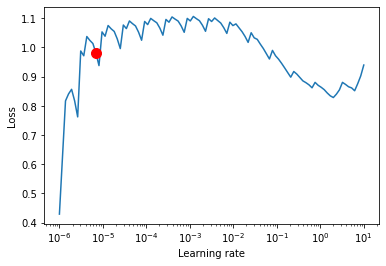

In [29]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [31]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=300,
    gpus=-1 if torch.cuda.is_available() else 0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Missing logger folder: lightning_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.1 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork      

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [34]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=100,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(16, 128),
    hidden_continuous_size_range=(8, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.0000001, 0.25),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=1.0),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-07-14 07:04:54,647] A new study created in memory with name: no-name-deacc47a-d874-4ee9-ac1f-a577cd518676
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:172: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2022-07-14 07:05:48,174] Trial 0 finished with value: 1.7701036930084229 and parameters: {'gradient_clip_val': 0.07110595762754922, 'hidden_size': 52, 'dropout': 0.14492695501056696, 'hidden_continuous_size': 16, 'attention_head_si

{'gradient_clip_val': 0.07147621914782185, 'hidden_size': 74, 'dropout': 0.14202474522407885, 'hidden_continuous_size': 42, 'attention_head_size': 3, 'learning_rate': 0.20668062643531035}


In [35]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [36]:
# calcualte mean absolute error on test set
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = best_tft.predict(test_dataloader)
(actuals - predictions).abs().mean()

tensor(1.0833)

In [37]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(test_dataloader, mode="raw", return_x=True)

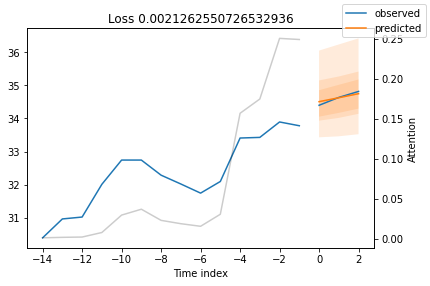

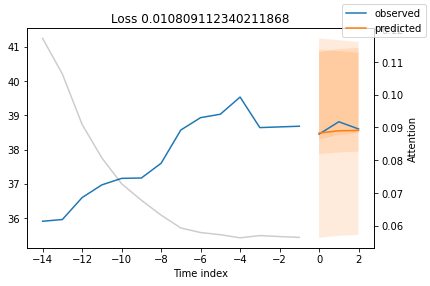

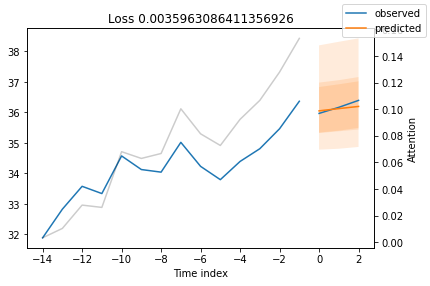

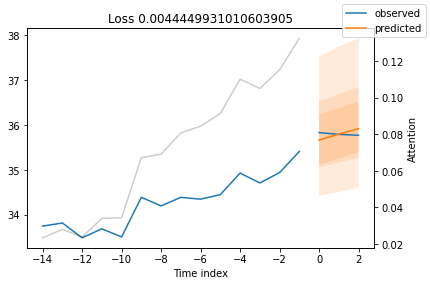

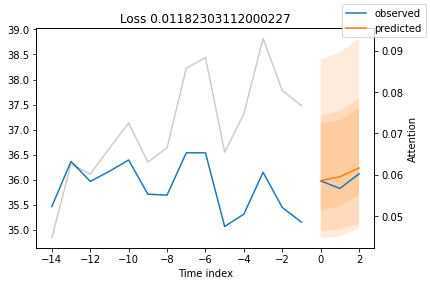

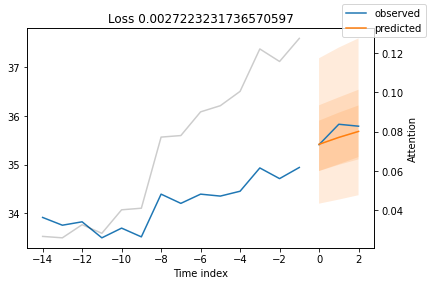

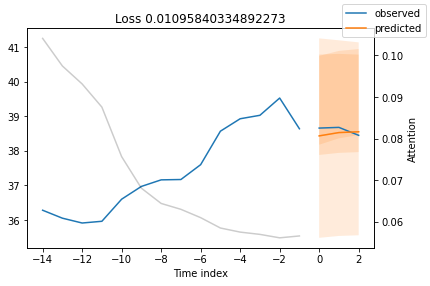

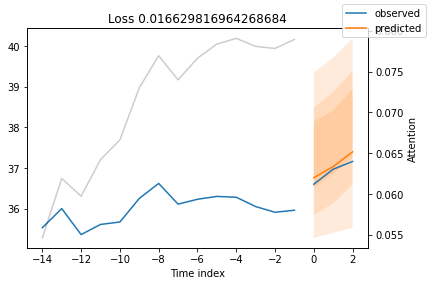

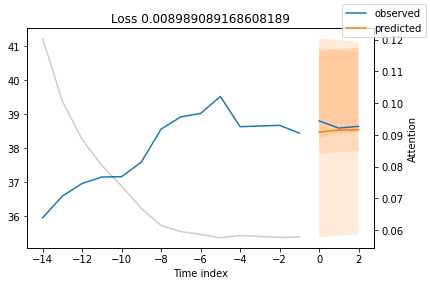

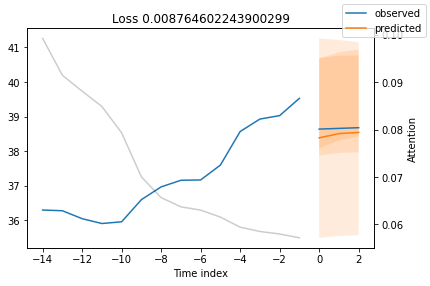

In [38]:
#display the best predictions
predictions = best_tft.predict(test_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=False)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );